In [1]:
import pandas as pd
import numpy as np
import copy
from util import *
import datetime

In [2]:
import importlib

# Data Description

Now we have three preprocessed files: `cleaned_incidents.csv`, `concat_1.csv` and `stations-i880n.csv`.

The usage of each file:

`cleaned_incidents.csv`: labeled incidents with upstream and downstream stations. <br>
`concat_1.csv`: speed, flow and occupancy information for each detector station in the first batch, across one year. <br>
`stations-i880n.csv`: list of detector stations.

In [3]:
incidents = pd.read_csv("data/I88N-processed/cleaned_incidents.csv")
data = pd.read_csv("data/I88N-processed/concat_1.csv")
stations = pd.read_csv("data/I88N-processed/stations-i880n.csv")

In [4]:
incidents.head(5)

,ID,Date,Time,Duration,Upstream,Upstream_Idx,Downstream,Downstream_Idx,Start DateTime,End DateTime,Rounded SDT,Rounded EDT
0,16917196,2017-01-01,02:14:00,0 days 00:14:00.000000000,400765,97.0,400844.0,98.0,2017-01-01 02:14:00,2017-01-01 02:28:00,2017-01-01 02:15:00,2017-01-01 02:30:00
1,16917233,2017-01-01,02:44:00,0 days 00:06:00.000000000,400309,30.0,400417.0,31.0,2017-01-01 02:44:00,2017-01-01 02:50:00,2017-01-01 02:45:00,2017-01-01 02:50:00
2,16917615,2017-01-01,09:25:00,0 days 00:12:00.000000000,408134,61.0,400685.0,62.0,2017-01-01 09:25:00,2017-01-01 09:37:00,2017-01-01 09:25:00,2017-01-01 09:35:00
3,16917677,2017-01-01,10:59:00,0 days 00:43:00.000000000,401888,38.0,400137.0,39.0,2017-01-01 10:59:00,2017-01-01 11:42:00,2017-01-01 11:00:00,2017-01-01 11:40:00
4,16917744,2017-01-01,11:52:00,0 days 00:09:00.000000000,408135,57.0,417665.0,58.0,2017-01-01 11:52:00,2017-01-01 12:01:00,2017-01-01 11:50:00,2017-01-01 12:00:00


In [5]:
data.head(5)

,Unnamed: 0,Station ID,Date,Time,Occupancy,Flow,Speed
0,0,408907,2017-01-01,00:00:00,2.1,95.0,68.8
1,1,408907,2017-01-01,00:05:00,2.0,91.0,68.4
2,2,408907,2017-01-01,00:10:00,2.0,91.0,68.4
3,3,408907,2017-01-01,00:15:00,1.9,86.0,68.5
4,4,408907,2017-01-01,00:20:00,1.8,82.0,68.5


In [6]:
stations.head(5)

,Unnamed: 0,Fwy,District,County,City,CA PM,Abs PM,Length,ID,Name,Lanes,Type,Sensor Type,HOV,MS ID,IRM
0,0,I880-N,4,Santa Clara,NaN,0.31,0.31,0.425,408907,SB/NB 280 rm-n-fly/diag,3,Mainline,loops,No,DT596,L3-N-37-880-00031
1,1,I880-N,4,Santa Clara,NaN,0.54,0.54,0.510,400951,Stevens Creek Blvd,4,Mainline,loops,No,DT938,L4-N-37-880-00054
2,2,I880-N,4,Santa Clara,San Jose,1.33,1.33,0.750,400057,Bascom Ave rm-n-diag,3,Mainline,loops,No,DT960,L3-N-37-880-00133
3,3,I880-N,4,Santa Clara,San Jose,2.04,2.04,0.685,400147,The Alameda rm-n-loop,3,Mainline,loops,No,DT963,L3-N-37-880-00204
4,4,I880-N,4,Santa Clara,San Jose,2.7,2.70,0.735,400343,Coleman Ave rm-n-diag,3,Mainline,loops,No,DT082,L3-N-37-880-00270


Transform date time format to datetime to facilitate comparison: this may take a while.

In [7]:
incidents["Date"] = incidents["Date"].apply(lambda x: pd.to_datetime(x).date())
incidents["Time"] = incidents["Time"].apply(lambda x: pd.to_datetime(x).time())
data["Date"] = data["Date"].apply(lambda x: pd.to_datetime(x).date())
data["Time"] = data["Time"].apply(lambda x: pd.to_datetime(x).time())

In [8]:
incidents["Rounded SDT"] = incidents["Rounded SDT"].apply(lambda x: pd.to_datetime(x))
incidents["Rounded EDT"] = incidents["Rounded EDT"].apply(lambda x: pd.to_datetime(x))

In [9]:
date_time = []
for idx, row in data.iterrows():
    date_time.append(datetime.datetime.combine(row["Date"], row["Time"]))
date_time = np.array(date_time)
data["Start DateTime"] = date_time

Write an algorithm: given two detector stations (a road segment), construct a feature vector $X$ for one of the stations consisting of first 8 month's data.  Then we can call `TSA_train(X)` to return the best alpha.

Tactic: for affected days, we replace the data during incident time with that from the nearest normal day.

In [10]:
feature_list = ["Occupancy", "Speed", "Flow"]

In [11]:
from datetime import timedelta 
X = TSA_construct_X(incidents, data, 400057, feature_list, datetime.date(2017, 1, 1), datetime.date(2017, 9, 1))

In [12]:
best_alpha, best_S1, best_S2, best_Y = TSA_train(X)

Variable 0:
0.0: 7.153835840658964
0.001: 7.161766253259109
0.002: 7.108607686707108
0.003: 7.060048829135211
0.004: 7.013136931423273
0.005: 6.964804856790735
0.006: 6.9162311490937665
0.007: 6.8660127609471395
0.008: 6.813681986596248
0.009000000000000001: 6.759400674576657
0.01: 6.703426491407142
0.011: 6.645895757241828
0.012: 6.587296070937664
0.013000000000000001: 6.527869862841802
0.014: 6.468080909176776
0.015: 6.408123841641723
0.016: 6.348424364750488
0.017: 6.289217375767576
0.018000000000000002: 6.230682720366038
0.019: 6.172994532130052
0.02: 6.116267622887778
0.021: 6.06063547963756
0.022: 6.006208466823852
0.023: 5.952982294633768
0.024: 5.901008703351169
0.025: 5.8503228766028625
0.026000000000000002: 5.8009092400550974
0.027: 5.752715205971189
0.028: 5.705830445277013
0.029: 5.660147975469558
0.03: 5.615610351224838
0.031: 5.5723352673653475
0.032: 5.530082975998923
0.033: 5.488950973194767
0.034: 5.448991342911032
0.035: 5.409820207447248
0.036000000000000004: 5.37177

0.301: 2.9416455284085044
0.302: 2.939357875950803
0.303: 2.937083546607929
0.304: 2.9348398848626287
0.305: 2.9325854262613738
0.306: 2.930351383430129
0.307: 2.92813958770615
0.308: 2.9259379942599795
0.309: 2.923753430301874
0.31: 2.9216027653962158
0.311: 2.9194431693943574
0.312: 2.9172984182834294
0.313: 2.915179609366021
0.314: 2.9130631234937328
0.315: 2.910978227492042
0.316: 2.9089708652806574
0.317: 2.9069392219432566
0.318: 2.904893169170399
0.319: 2.9029476823362543
0.32: 2.9009606436806274
0.321: 2.8990732022861385
0.322: 2.897372465748111
0.323: 2.895405296291866
0.324: 2.8933610488912294
0.325: 2.89129280978787
0.326: 2.889735443881661
0.327: 2.8878774360061357
0.328: 2.8864623197409043
0.329: 2.8851199463741604
0.33: 2.8825520235224
0.331: 2.8811055492177817
0.332: 2.8800637470886112
0.333: 2.8791321742049525
0.334: 2.877793974249253
0.335: 2.8770842367629217
0.336: 2.872427123484258
0.337: 2.8702233113157174
0.338: 2.869595770375255
0.339: 2.8680407536400576
0.34: 2.8

0.603: 2.6853718193016576
0.604: 2.685475327141237
0.605: 2.685582300982852
0.606: 2.6856808375824723
0.607: 2.6858015126620765
0.608: 2.6859207865572388
0.609: 2.686032864523287
0.61: 2.6861638173260576
0.611: 2.686290200372606
0.612: 2.686407067680086
0.613: 2.6865778368641973
0.614: 2.6866889817626394
0.615: 2.6868486164310497
0.616: 2.6869893054572445
0.617: 2.687164011814456
0.618: 2.6873006963492236
0.619: 2.6874847005499123
0.62: 2.687636612935844
0.621: 2.6878178269516315
0.622: 2.6880370156796722
0.623: 2.688225999802946
0.624: 2.6883892282845787
0.625: 2.688580249301938
0.626: 2.688807550241724
0.627: 2.689060505719798
0.628: 2.6893003087541008
0.629: 2.690096606918519
0.63: 2.689641852239857
0.631: 2.6899442196053958
0.632: 2.690167314413806
0.633: 2.6903758083063374
0.634: 2.6904842703170653
0.635: 2.691039673276549
0.636: 2.6911118039568915
0.637: 2.691356018520146
0.638: 2.691573922900655
0.639: 2.691922973773707
0.64: 2.6922281418306846
0.641: 2.6925027195900006
0.642: 2

0.908: 2.8915935922463376
0.909: 2.8930585097360573
0.91: 2.895865034757714
0.911: 2.897149221803567
0.912: 2.8989463711435692
0.913: 2.9005177616798763
0.914: 2.902695056140618
0.915: 2.9027143796338764
0.916: 2.9039553754274934
0.917: 2.9070050372638896
0.918: 2.904831421202716
0.919: 2.9071944060822315
0.92: 2.9067539849598836
0.921: 2.9075237041059396
0.922: 2.908821985631653
0.923: 2.9100808870235957
0.924: 2.9113233694712877
0.925: 2.9126977727407946
0.926: 2.914021446054784
0.927: 2.915309182478279
0.928: 2.9165025207327915
0.929: 2.9177908789581513
0.93: 2.918978176018545
0.931: 2.9203154867200203
0.932: 2.921698980588827
0.933: 2.9229206358226163
0.934: 2.9243026090385684
0.935: 2.9255409570636877
0.936: 2.9269412743522
0.937: 2.928246818596474
0.9380000000000001: 2.9295389654176933
0.9390000000000001: 2.9308953216773577
0.9400000000000001: 2.932256482648069
0.9410000000000001: 2.933678653068914
0.9420000000000001: 2.934868308374486
0.9430000000000001: 2.9362323481591703
0.944

0.20800000000000002: 5.271174536356926
0.209: 5.256132412920131
0.21: 5.239162666725458
0.211: 5.2298957621506545
0.212: 5.220753857091946
0.213: 5.207032596345373
0.214: 5.195897669167583
0.215: 5.183676481890446
0.216: 5.171527152645984
0.217: 5.160973486169903
0.218: 5.1474413336159905
0.219: 5.131464774548741
0.22: 5.1221580959131305
0.221: 5.111465956524374
0.222: 5.100286128063579
0.223: 5.088619985768664
0.224: 5.067496172963757
0.225: 5.060725716404128
0.226: 5.052064535147448
0.227: 5.041551722405939
0.228: 5.0312766601931775
0.229: 5.016710970608581
0.23: 5.003510081787341
0.231: 4.9837983026393955
0.232: 4.966359129451146
0.233: 4.944699222062357
0.234: 4.954551317585569
0.23500000000000001: 4.952474120694704
0.23600000000000002: 4.940477856019466
0.23700000000000002: 4.928087237333079
0.23800000000000002: 4.911689251652532
0.23900000000000002: 4.904243478886323
0.24: 4.893367741298203
0.241: 4.887840749478358
0.242: 4.879125158657769
0.243: 4.872142060529377
0.244: 4.854986

0.512: 3.285720310507281
0.513: 3.27953490213044
0.514: 3.278178545198116
0.515: 3.2732889327949195
0.516: 3.271434699778798
0.517: 3.2688735130272866
0.518: 3.2650552700646256
0.519: 3.2625179344872497
0.52: 3.2578870261321464
0.521: 3.254946944860767
0.522: 3.2530734229923692
0.523: 3.2502683243540376
0.524: 3.2449507310612145
0.525: 3.2436283915757715
0.526: 3.2408577399021548
0.527: 3.235578567118184
0.528: 3.2317948745294496
0.529: 3.2295601143618904
0.53: 3.2254928228494544
0.531: 3.224735078102776
0.532: 3.2203605147873873
0.533: 3.209644266292578
0.534: 3.190510113557847
0.535: 3.1828444367681574
0.536: 3.1786327094454436
0.537: 3.175320001631227
0.538: 3.172312777733327
0.539: 3.170143295570693
0.54: 3.166719879019388
0.541: 3.1635117167035887
0.542: 3.1601329701199004
0.543: 3.1577820468218945
0.544: 3.1579014920685724
0.545: 3.1742132745159504
0.546: 3.178833932588693
0.547: 3.1752668392561025
0.548: 3.173238465697905
0.549: 3.1722779891025303
0.55: 3.167481140895163
0.551: 

0.8190000000000001: 2.6944919417121795
0.8200000000000001: 2.6940848441199687
0.8210000000000001: 2.6932509920244496
0.8220000000000001: 2.6924852457298893
0.8230000000000001: 2.6911754826403262
0.8240000000000001: 2.6899419473192987
0.8250000000000001: 2.6894956906150953
0.8260000000000001: 2.6886957181558264
0.8270000000000001: 2.6881417564410284
0.8280000000000001: 2.687473730811017
0.8290000000000001: 2.6865720947798915
0.8300000000000001: 2.686215667331481
0.8310000000000001: 2.68550532894683
0.8320000000000001: 2.685835481021199
0.833: 2.6853206286523683
0.834: 2.684564416776486
0.835: 2.6843721003522694
0.836: 2.6825841333067975
0.837: 2.683073927202025
0.838: 2.682402622680747
0.839: 2.68229991169234
0.84: 2.681702464774933
0.841: 2.6806106059786914
0.842: 2.680588104033833
0.843: 2.6800081873339345
0.844: 2.6777097537207752
0.845: 2.67708175995171
0.846: 2.6755133400478415
0.847: 2.6750156675984345
0.848: 2.6746999345834492
0.849: 2.6749285585651186
0.85: 2.6758609683530143
0.

0.115: 42.246328430261926
0.116: 42.051904064237604
0.117: 41.84407398706143
0.11800000000000001: 41.65905553188223
0.11900000000000001: 41.50591890226501
0.12: 41.25308251400274
0.121: 41.14314175960089
0.122: 40.935793034921765
0.123: 40.76941601673113
0.124: 40.60785600775892
0.125: 40.3773777981718
0.126: 40.248972753553076
0.127: 40.080302165559
0.128: 39.91535079018679
0.129: 39.78782136223846
0.13: 39.62408361384695
0.131: 39.455891221379055
0.132: 39.301988640659104
0.133: 39.179266509615495
0.134: 39.01483466605532
0.135: 38.85517160082763
0.136: 38.72444746738498
0.137: 38.60148923626998
0.138: 38.46177501554624
0.139: 38.33444787296363
0.14: 38.21493449655475
0.14100000000000001: 38.09287141389166
0.14200000000000002: 37.97704606352445
0.14300000000000002: 37.854547983510585
0.14400000000000002: 37.73931917063167
0.145: 37.6287368828814
0.146: 37.518631614393264
0.147: 37.40719676393615
0.148: 37.30474732041208
0.149: 37.20255854847014
0.15: 37.100499193980475
0.151: 36.9989

0.417: 32.91810653280029
0.418: 32.924107198655875
0.419: 32.93511791947023
0.42: 32.941674858664165
0.421: 32.95674523046207
0.422: 32.96264060900949
0.423: 32.970279988074886
0.424: 32.98123672425009
0.425: 32.991008789218036
0.426: 33.00525730981287
0.427: 33.017059520123425
0.428: 33.027288320140705
0.429: 33.037011430696076
0.43: 33.05402273802234
0.431: 33.05963207828828
0.432: 33.07326513720269
0.433: 33.08572582335509
0.434: 33.096723842899245
0.435: 33.10979668054344
0.436: 33.12254286722738
0.437: 33.134642676705056
0.438: 33.14782486991666
0.439: 33.159863723034945
0.44: 33.173118544830096
0.441: 33.18582817808825
0.442: 33.199008572892254
0.443: 33.212104706243714
0.444: 33.225363038843156
0.445: 33.23868178443416
0.446: 33.25181778547747
0.447: 33.265232273424395
0.448: 33.2792317183777
0.449: 33.29211002444293
0.45: 33.30564693706149
0.451: 33.319078246510635
0.452: 33.33302386243573
0.453: 33.34695328652102
0.454: 33.361053886712604
0.455: 33.3752740423806
0.456: 33.3880

0.723: 38.39684515250264
0.724: 38.418831116070336
0.725: 38.44204695382123
0.726: 38.46467361418777
0.727: 38.488068580494705
0.728: 38.51149622527416
0.729: 38.53438511092021
0.73: 38.55787529885961
0.731: 38.580962428434916
0.732: 38.604023446973024
0.733: 38.627564416706505
0.734: 38.65100676517983
0.735: 38.67436755681063
0.736: 38.69777588420311
0.737: 38.72132096520813
0.738: 38.744729171814946
0.739: 38.768324353339146
0.74: 38.79196591850088
0.741: 38.81551575046585
0.742: 38.83927667049711
0.743: 38.862962800851186
0.744: 38.886645968432134
0.745: 38.910418643560554
0.746: 38.93422510005181
0.747: 38.95812565517626
0.748: 38.98224527566336
0.749: 39.006046931070706
0.75: 39.03012127890526
0.751: 39.05408298907459
0.752: 39.07825253543358
0.753: 39.10200728387786
0.754: 39.12673744523213
0.755: 39.150638273145745
0.756: 39.17422925362558
0.757: 39.198433936497985
0.758: 39.22327028791578
0.759: 39.247088018823916
0.76: 39.27153927547083
0.761: 39.29662703534889
0.762: 39.32006

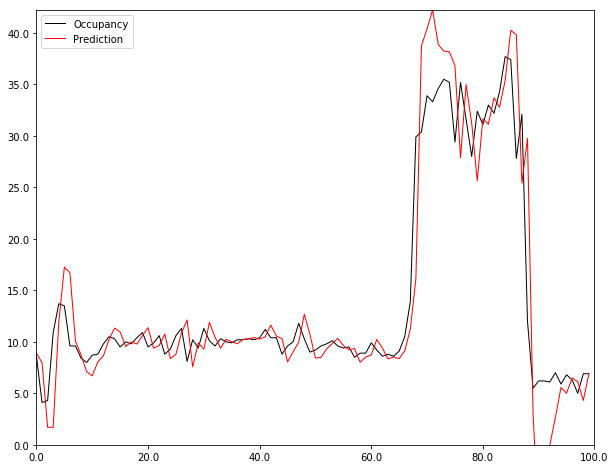

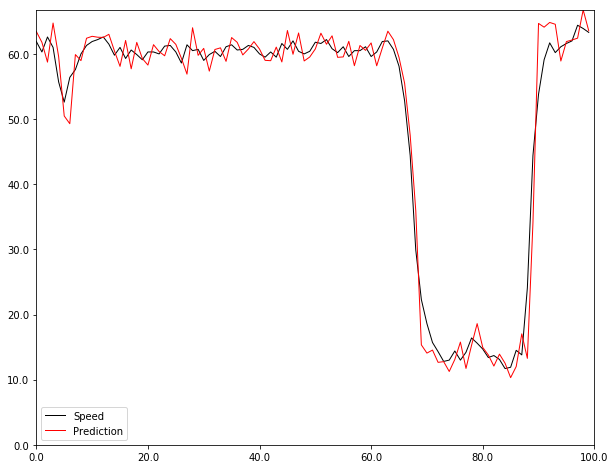

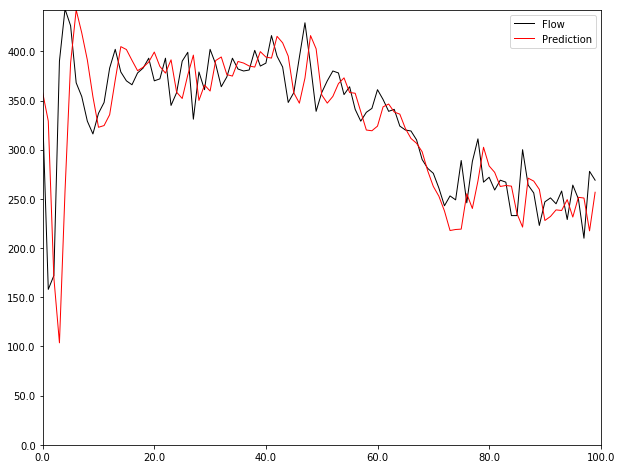

In [13]:
visualize_all(X[:, 1000:1100], best_Y[:, 1000:1100])

# Construct Positive and Negative Samples for SVM

$$ best\_Y\_list = [best\_Y\_B, best\_Y\_E] $$
$$normal\_train\_data\_list = [normal\_train\_data\_B, normal\_train\_data\_E]$$

The feature vector at time $t$ will look like this:
$$Z(m, n, t) = Z(0, 0, t) = [f(B, t-1), f(B, t), f(E, t-1), f(E, t)],$$
where $$f(i, t) = [X(i, t), Y(i, t), X(i, t) - Y(i, t)]^T.$$

Each vector $X, Y$ is denoted, same as before, as
$$X(i, t) = [occupancy, speed, flow]$$

We should have the following algorithms.

```
    ALGORITHM t_to_idx(df_S, t):
        return (idx of time t in df_S)
```

In [14]:
def t_to_idx(df_S, t):
    new_idx = np.arange(df_S.index.values.size)
    df_S["Idx"] = new_idx
    df_S_t = df_S.loc[(df_S["Date"] == t.date()) & (df_S["Time"] == t.time())]
    
    return None if df_S_t.empty else df_S_t["Idx"].values[0]

```
    ALGORITHM construct_vector(X_S, idx):
        occupancy = X_S[idx]["occupancy"]
        speed = X_S[idx]["speed"]
        flow = X_S[idx]["flow"]
        return [occupancy, speed, flow]
```

In [ ]:
def construct_vector(X_S, idx):
    return X_S[:, idx]

```
    ALGORITHM construct_f(df_S, X_S, Y_S, t):
        idx = t_to_idx(df_S, t)
        X_S_t = construct_vector(X_S, idx)
        Y_S_t = construct_vector(Y_S, idx)
        f_S_t = concatenation of X_S_t, Y_S_t, and X_S_t - Y_S_t
        return f_S_t
```

In [25]:
def construct_f(df_S, X_S, Y_S, t):
    f_S_t = np.array([])
    idx = t_to_idx(df_S, t)
    X_S_t = construct_vector(X_S, idx)
    Y_S_t = construct_vector(Y_S, idx)
    diff_X_Y = X_S_t - Y_S_t
    
    f_S_t = np.append(f_S_t, X_S_t)
    f_S_t = np.append(f_S_t, Y_S_t)
    f_S_t = np.append(f_S_t, diff_X_Y)
    
    return f_S_t

We also want a utility function, given $t$ and number of time lags $n$, generate a list of t with frequency of 5 minutes up to $(t - 5n)\ min$:

```
    ALGORITHM construct_t_list(t, num_lags):
        t_list = []
        for i from num_lags to 0 do:
            t_list.append(t - 5 * i  minutes)
        return t_list
```

In [26]:
def construct_t_list(t, num_lags):
    t_list = []
    for i in range(num_lags, -1, -1):
        t_list.append(t - datetime.timedelta(minutes=5*i))
    return t_list

Construct feature for a road segment:
```
    ALGORITHM construct_feature(df_list, X_list, TSA_Y_list, t_list):
        z = empty vector
        for i, X in enumerate(X_list) do:
            for j, t in enumerate(t_list) do:
                z.append(construct_f(df_list[i], X, TSA_Y_list[i], t))
        return z
```

In [27]:
def construct_feature(df_S, X, TSA_Y, t_list_at_t):
    # construct partial feature for station X
    z_S = np.array([])
    for i, t in enumerate(t_list_at_t):
        z_S = np.append(z_S, construct_f(df_S, X, TSA_Y, t))
    return z_S

In [28]:
# here we assume fixed time lags for each detector station
# also assume time lag is one at present
num_lags = 1
svm_features = ["X", "Y", "Diff(X, Y)"]
def construct_features(df_list, X_list, TSA_Y_list, t_list):
    # for each timestamp, there is one feature vector: first dimension
    num_timestamps = len(t_list)
    # for each svm feature vector, the number of values = number of stations * number of f for each station * number of values for each f
    num_values = len(X_list) * (num_lags + 1) * (len(feature_list) * len(svm_features))
    feature_matrix = np.zeros((num_timestamps, num_values))
    for i, t in enumerate(t_list):
        z = np.array([])
        t_list_at_t = construct_t_list(t, num_lags)
        for j, X in enumerate(X_list):
            z = np.append(z, construct_feature(df_list[j], X, TSA_Y_list[j], t_list_at_t))
        feature_matrix[i, :] = z
        print(str(t) + " has been constructed.")
    return feature_matrix

Given two stations, check the intersection days that both of them have no accidents.
```
    ALGORITHM intersection_days(df_B, df_E, incidents):
        days_B = df_B["Date"]
        days_E = df_E["Date"]
        affected_days = incidents[upstream = B and downstream = E].dates
        days = all days in days_B, days_E but not in affected_days
        return days
```

In [29]:
def intersection_days(B_id, E_id, df_B, df_E, incidents):
    days_B = df_B["Date"].unique()
    days_E = df_E["Date"].unique()
    affected_days = incidents.loc[incidents["Upstream"].isin([B_id, E_id])]["Date"].unique()
    # take intersection
    days = [day for day in days_B if (day in days_E and day not in affected_days)]
    return days

In [30]:
def construct_normal_day(df_S, day):
    return df_S.loc[df_S["Date"] == day]["Time"].unique()

# Test

## TSA

In [16]:
stations.iloc[7]["ID"]

400122

In [17]:
stations.iloc[8]["ID"]

401541

In [18]:
X_400122 = TSA_construct_X(incidents, data, 400122, feature_list, datetime.date(2017, 1, 1), datetime.date(2017, 9, 1))

In [19]:
X_400122

array([[  2.9,   2.6,   3.1, ...,   1.4,   1.3,   1.2],
       [ 68.2,  68.1,  68.6, ...,  68. ,  68. ,  68. ],
       [136. , 125. , 146. , ...,  79. ,  75. ,  67. ]])

In [20]:
X_401541 = TSA_construct_X(incidents, data, 401541, feature_list, datetime.date(2017, 1, 1), datetime.date(2017, 9, 1))

In [21]:
best_alpha_400122, best_S1_400122, best_S2_400122, best_Y_400122 = TSA_train(X_400122)
best_alpha_401541, best_S1_401541, best_S2_401541, best_Y_401541 = TSA_train(X_401541)

Variable 0:
0.0: 7.469440394091288
0.001: 7.439926246094781
0.002: 7.38709117485351
0.003: 7.344769631427016
0.004: 7.300054771859337
0.005: 7.249916715459328
0.006: 7.196354069179853
0.007: 7.138400045691367
0.008: 7.076235049937774
0.009000000000000001: 7.0103429785545
0.01: 6.9414929268989765
0.011: 6.87032360703782
0.012: 6.796974303134697
0.013000000000000001: 6.722184432570002
0.014: 6.646899196502256
0.015: 6.571219691653509
0.016: 6.495746054662946
0.017: 6.420797227381658
0.018000000000000002: 6.34665459231881
0.019: 6.273692011138746
0.02: 6.201877698157398
0.021: 6.131525680194773
0.022: 6.06270102085193
0.023: 5.995466274200449
0.024: 5.929923484789264
0.025: 5.866034704973167
0.026000000000000002: 5.803858350943005
0.027: 5.743359528701392
0.028: 5.684558734928091
0.029: 5.627404422891955
0.03: 5.571832240405567
0.031: 5.517858415974199
0.032: 5.465412803213401
0.033: 5.414449051924429
0.034: 5.364919264929994
0.035: 5.316721464365156
0.036000000000000004: 5.26990937385336

0.301: 2.745318543748499
0.302: 2.7438995794241032
0.303: 2.7424903051082152
0.304: 2.7410988073310323
0.305: 2.739721270766606
0.306: 2.7383431485500047
0.307: 2.73698570581061
0.308: 2.735639361031579
0.309: 2.7343218255112416
0.31: 2.733004422403214
0.311: 2.7316858479608466
0.312: 2.730388771544631
0.313: 2.729112977585598
0.314: 2.7278298347506995
0.315: 2.7265995850027713
0.316: 2.7253662306335573
0.317: 2.7241332667474634
0.318: 2.722911872042138
0.319: 2.7217019499889
0.32: 2.720536011890636
0.321: 2.71949578333165
0.322: 2.7184770099149542
0.323: 2.7174093195366407
0.324: 2.716044358340849
0.325: 2.7150376314100826
0.326: 2.7138605332146444
0.327: 2.713405988451584
0.328: 2.7123637772180955
0.329: 2.711699367486641
0.33: 2.710202208453173
0.331: 2.7091369248400703
0.332: 2.7084472001025564
0.333: 2.707675143808205
0.334: 2.7124731287992048
0.335: 2.715775096202749
0.336: 2.7133513551150865
0.337: 2.712863369977882
0.338: 2.7132650190591425
0.339: 2.7147023717495746
0.34: 2.712

0.601: 2.6414979627837205
0.602: 2.6418342881139667
0.603: 2.6421459683821102
0.604: 2.642484780126888
0.605: 2.642798220527297
0.606: 2.643134457155222
0.607: 2.6435111878166904
0.608: 2.6438889573029414
0.609: 2.644278868396362
0.61: 2.6446639899149287
0.611: 2.6450391394982393
0.612: 2.6452947717953714
0.613: 2.64572986395275
0.614: 2.646045788919836
0.615: 2.646684101685725
0.616: 2.647168259199383
0.617: 2.64749922571917
0.618: 2.6479282033157343
0.619: 2.6483780975672278
0.62: 2.6526660552646772
0.621: 2.6529530662219956
0.622: 2.6534609863072065
0.623: 2.6532603664431145
0.624: 2.6532955048669304
0.625: 2.6534755137652044
0.626: 2.654867974875018
0.627: 2.6552813027043873
0.628: 2.6558795030073066
0.629: 2.656409886796777
0.63: 2.6562191555899015
0.631: 2.6563011458420465
0.632: 2.6567617749478853
0.633: 2.657466556331128
0.634: 2.657390795713568
0.635: 2.6578923204685503
0.636: 2.6591687579923677
0.637: 2.6591120764416716
0.638: 2.658363894322176
0.639: 2.656642322304545
0.64: 

0.906: 2.867729879133982
0.907: 2.868922168681087
0.908: 2.870265884070143
0.909: 2.8715382359151085
0.91: 2.875131261425504
0.911: 2.876047262601224
0.912: 2.877584481308215
0.913: 2.8780337202369934
0.914: 2.8796279862063874
0.915: 2.8814047369715174
0.916: 2.8823627909938367
0.917: 2.8838482552347524
0.918: 2.884548501959284
0.919: 2.8853850258464813
0.92: 2.886019442623591
0.921: 2.887774440320779
0.922: 2.888356916375895
0.923: 2.887992176948812
0.924: 2.889351517225737
0.925: 2.890541030528268
0.926: 2.891741621574144
0.927: 2.894115126229758
0.928: 2.89419659790908
0.929: 2.895402208363286
0.93: 2.8965266212548166
0.931: 2.8978331892203952
0.932: 2.8990301683075397
0.933: 2.9004339462215962
0.934: 2.9014918635019575
0.935: 2.902901183305376
0.936: 2.9041291940609613
0.937: 2.9054117988187356
0.9380000000000001: 2.90676242164263
0.9390000000000001: 2.9078809661337233
0.9400000000000001: 2.909165660335359
0.9410000000000001: 2.9105176835264217
0.9420000000000001: 2.911734790234646

0.20700000000000002: 4.871573348042676
0.20800000000000002: 4.864572746231551
0.209: 4.852563592147225
0.21: 4.8399890329622846
0.211: 4.834167051239345
0.212: 4.827046673792767
0.213: 4.8138949919947915
0.214: 4.8031741846290705
0.215: 4.79203472492511
0.216: 4.783509867458837
0.217: 4.777799668757021
0.218: 4.766809954104085
0.219: 4.756427846088905
0.22: 4.742566011751584
0.221: 4.737719485227749
0.222: 4.73053168164855
0.223: 4.716524374139751
0.224: 4.703639395061509
0.225: 4.680213689581603
0.226: 4.679395849615718
0.227: 4.680693356679088
0.228: 4.670661662677171
0.229: 4.659985066387313
0.23: 4.649435912763484
0.231: 4.642667658661022
0.232: 4.6300533300956275
0.233: 4.62429512723993
0.234: 4.6084903610486805
0.23500000000000001: 4.6090899450762
0.23600000000000002: 4.599055183083106
0.23700000000000002: 4.588868380481978
0.23800000000000002: 4.587368243324922
0.23900000000000002: 4.576309368806485
0.24: 4.575921536060915
0.241: 4.569719324386108
0.242: 4.565639893868561
0.243:

0.509: 3.3438166022956777
0.51: 3.347703448260637
0.511: 3.3485715954647866
0.512: 3.3479351491094196
0.513: 3.3392240963991875
0.514: 3.3244023425826104
0.515: 3.32011581433836
0.516: 3.3211578665418284
0.517: 3.326035956503605
0.518: 3.3210281866627347
0.519: 3.324445555863184
0.52: 3.30918034611566
0.521: 3.314703615161092
0.522: 3.3158395113140826
0.523: 3.3171452710817566
0.524: 3.3137510667344667
0.525: 3.3117757117831603
0.526: 3.3093960645012075
0.527: 3.306202940918712
0.528: 3.304662707836576
0.529: 3.3012431607046047
0.53: 3.2984142550350195
0.531: 3.2952826737352447
0.532: 3.2929547848717626
0.533: 3.291110736754332
0.534: 3.290173777142263
0.535: 3.287058172434396
0.536: 3.284203317667652
0.537: 3.2813637655205374
0.538: 3.2784618569573527
0.539: 3.277451268893632
0.54: 3.27463594541564
0.541: 3.2724626006863144
0.542: 3.2720697348290733
0.543: 3.269181921934307
0.544: 3.2668735575664756
0.545: 3.263853181346621
0.546: 3.2603117651474602
0.547: 3.25764892554851
0.548: 3.25

0.8150000000000001: 2.895309293332566
0.8160000000000001: 2.8960712577974386
0.8170000000000001: 2.897151413030848
0.8180000000000001: 2.89625810282604
0.8190000000000001: 2.8951792005752774
0.8200000000000001: 2.8951917261994624
0.8210000000000001: 2.895016020592392
0.8220000000000001: 2.895984097047778
0.8230000000000001: 2.896802783518773
0.8240000000000001: 2.8961246209839513
0.8250000000000001: 2.895995281391182
0.8260000000000001: 2.8941001879138093
0.8270000000000001: 2.8945037312255666
0.8280000000000001: 2.8932154654732596
0.8290000000000001: 2.892004935944235
0.8300000000000001: 2.891473656493511
0.8310000000000001: 2.890096822378433
0.8320000000000001: 2.888281022186193
0.833: 2.8881986640293853
0.834: 2.8862208399321436
0.835: 2.8849386601823213
0.836: 2.8858265915654697
0.837: 2.8847605879735587
0.838: 2.8849104115097
0.839: 2.8845733784266496
0.84: 2.8842869813676306
0.841: 2.884051679052918
0.842: 2.883639004291745
0.843: 2.8831860269203697
0.844: 2.8837073762753493
0.84

0.109: 42.25387773211336
0.11: 42.04015335509673
0.111: 41.75934154752148
0.112: 41.476336770765236
0.113: 41.34687426547457
0.114: 41.09986789870671
0.115: 40.91019679550776
0.116: 40.70621951178551
0.117: 40.489700710208055
0.11800000000000001: 40.31234649917007
0.11900000000000001: 40.12537186073089
0.12: 39.919215520599785
0.121: 39.74577806257724
0.122: 39.58289620396774
0.123: 39.41729661257073
0.124: 39.25921158466235
0.125: 39.07014902019244
0.126: 38.92325249235514
0.127: 38.77386520996946
0.128: 38.608297568643216
0.129: 38.455248416191644
0.13: 38.30507132508996
0.131: 38.138964098387696
0.132: 37.97428646528476
0.133: 37.846153127027286
0.134: 37.6971007025308
0.135: 37.55967623452483
0.136: 37.42326769677816
0.137: 37.28967099742079
0.138: 37.158833266612746
0.139: 37.028733441194106
0.14: 36.902822672830126
0.14100000000000001: 36.77805776649001
0.14200000000000002: 36.66980800802341
0.14300000000000002: 36.546640519847955
0.14400000000000002: 36.424775324341304
0.145: 36

0.41200000000000003: 31.584314785696055
0.41300000000000003: 31.591728810696296
0.41400000000000003: 31.605537992062626
0.41500000000000004: 31.60504717895926
0.41600000000000004: 31.616613304402854
0.417: 31.61232702205498
0.418: 31.63783029229144
0.419: 31.63800845863068
0.42: 31.642256195540746
0.421: 31.678897730412274
0.422: 31.69487325021366
0.423: 31.720380651064552
0.424: 31.69667788758328
0.425: 31.701570101557415
0.426: 31.7032475147709
0.427: 31.716944964782005
0.428: 31.72610525657491
0.429: 31.736335302033584
0.43: 31.751036748533004
0.431: 31.76065115885008
0.432: 31.771705613604244
0.433: 31.78376822315917
0.434: 31.79528843266204
0.435: 31.807549607212493
0.436: 31.819829824010267
0.437: 31.83356402778437
0.438: 31.84586564304786
0.439: 31.859469107077466
0.44: 31.87194289566705
0.441: 31.88536844225217
0.442: 31.89883031484897
0.443: 31.91216642360234
0.444: 31.925301318497993
0.445: 31.93893369627499
0.446: 31.952319289790193
0.447: 31.965872936278767
0.448: 31.979646

0.715: 37.05495690739383
0.716: 37.07713098758941
0.717: 37.09943809245177
0.718: 37.12414755452235
0.719: 37.146467981187286
0.72: 37.16950254456957
0.721: 37.19314827007623
0.722: 37.21652708480918
0.723: 37.24006949607686
0.724: 37.263929782363455
0.725: 37.28753433638629
0.726: 37.311249959717976
0.727: 37.33508884910955
0.728: 37.3588251913502
0.729: 37.38269954658243
0.73: 37.40661779464028
0.731: 37.43046590130559
0.732: 37.45445030470274
0.733: 37.47839830507771
0.734: 37.50239863328925
0.735: 37.526441842708174
0.736: 37.55052805269172
0.737: 37.57462153871578
0.738: 37.5987880739181
0.739: 37.622932878068475
0.74: 37.647129320348235
0.741: 37.67142431225881
0.742: 37.69572160439312
0.743: 37.720236985489805
0.744: 37.7444002982181
0.745: 37.76894620371463
0.746: 37.793337881183284
0.747: 37.817934934081975
0.748: 37.84317133801663
0.749: 37.86807829846642
0.75: 37.89184866651613
0.751: 37.92039488448098
0.752: 37.94623112752333
0.753: 37.97548730424158
0.754: 38.0026300801370

0.019: 4.421322320557083
0.02: 4.352391799082767
0.021: 4.284916636595681
0.022: 4.218898974265979
0.023: 4.154482955066769
0.024: 4.0918018386668535
0.025: 4.030800625642818
0.026000000000000002: 3.9715725805878836
0.027: 3.9140235271315498
0.028: 3.8583178267477782
0.029: 3.8042322481378705
0.03: 3.75188000754326
0.031: 3.70130016950654
0.032: 3.652320367631673
0.033: 3.6048846380750077
0.034: 3.5590378140421524
0.035: 3.5145384173522256
0.036000000000000004: 3.4715321994570436
0.037: 3.429968401535016
0.038: 3.389856285156217
0.039: 3.350944674196956
0.04: 3.3134047373053424
0.041: 3.2768950303633297
0.042: 3.2414885346475
0.043000000000000003: 3.207503616421482
0.044: 3.1744126554810217
0.045: 3.1422254838485686
0.046: 3.1116691616855054
0.047: 3.0822842909961654
0.048: 3.0523984916036038
0.049: 3.0240283396318905
0.05: 2.996934543332066
0.051000000000000004: 2.9704136421065193
0.052000000000000005: 2.944880720416792
0.053: 2.919820688680443
0.054: 2.89549194921936
0.055: 2.8726260

0.319: 1.8424650281729031
0.32: 1.8425861169599023
0.321: 1.8429062403261878
0.322: 1.8425974809570087
0.323: 1.8429035513880616
0.324: 1.842498139985764
0.325: 1.8434426558492278
0.326: 1.8434789171326587
0.327: 1.844518959862433
0.328: 1.8451838768675672
0.329: 1.8457449305751206
0.33: 1.8443572843486147
0.331: 1.8450081614131382
0.332: 1.846135032664187
0.333: 1.8464580360867202
0.334: 1.8566467495883046
0.335: 1.854840856519506
0.336: 1.8485493846374408
0.337: 1.8476721272947716
0.338: 1.8508838248338249
0.339: 1.8552921401010958
0.34: 1.855828952993172
0.341: 1.8479909984566045
0.342: 1.8494649434812156
0.343: 1.8481092904431051
0.34400000000000003: 1.848375868006529
0.34500000000000003: 1.8472373003909048
0.34600000000000003: 1.8508661900554606
0.34700000000000003: 1.846823122369938
0.34800000000000003: 1.8464820207805304
0.34900000000000003: 1.8472273368189367
0.35000000000000003: 1.847551897814794
0.35100000000000003: 1.8477672628210593
0.352: 1.8544911687782708
0.353: 1.845363

0.616: 1.9664613524583503
0.617: 1.9671653700926577
0.618: 1.9678911751445392
0.619: 1.9686406387054185
0.62: 1.9693193352801024
0.621: 1.9700789517659538
0.622: 1.9708989765077325
0.623: 1.9716274498967086
0.624: 1.9723138755416654
0.625: 1.9730524786661523
0.626: 1.9737535199414882
0.627: 1.974671759338628
0.628: 1.975369594692901
0.629: 1.9760982231192554
0.63: 1.9770633343349469
0.631: 1.977606090404508
0.632: 1.9784511712118984
0.633: 1.9791730271081351
0.634: 1.9799400765583162
0.635: 1.9812775757588068
0.636: 1.9814575565085288
0.637: 1.9823155575215559
0.638: 1.9830416000950084
0.639: 1.983770021457644
0.64: 1.984599326368089
0.641: 1.9853551137943006
0.642: 1.9862351010172383
0.643: 1.9868091589684371
0.644: 1.9877255825276203
0.645: 1.988515515834395
0.646: 1.9893668404855533
0.647: 1.9903414855421602
0.648: 1.9909908918277532
0.649: 1.991650367363199
0.65: 1.9924802719348353
0.651: 1.9934474358970693
0.652: 1.9943075135565578
0.653: 1.9949083164852006
0.654: 1.99604267893323

0.92: 2.2595993765875595
0.921: 2.2606288524810094
0.922: 2.2619076102244637
0.923: 2.263199676315698
0.924: 2.264381902227567
0.925: 2.2656043275649402
0.926: 2.266857098901969
0.927: 2.2681194403592744
0.928: 2.269447383231326
0.929: 2.2704818674942824
0.93: 2.2717715245382264
0.931: 2.27297226899819
0.932: 2.2743456903925914
0.933: 2.2755373461514257
0.934: 2.2767319255097167
0.935: 2.2781247826070077
0.936: 2.2793349940066516
0.937: 2.280515766123739
0.9380000000000001: 2.281859469291973
0.9390000000000001: 2.283145084494488
0.9400000000000001: 2.28451573646733
0.9410000000000001: 2.28568190284134
0.9420000000000001: 2.2868322981418463
0.9430000000000001: 2.28821364323094
0.9440000000000001: 2.289669783318542
0.9450000000000001: 2.290760708904857
0.9460000000000001: 2.292286931452131
0.9470000000000001: 2.2933841645464863
0.9480000000000001: 2.2946899176086117
0.9490000000000001: 2.2960135789290232
0.9500000000000001: 2.2973737583681046
0.9510000000000001: 2.2987506046138173
0.9520

0.216: 3.207123377710498
0.217: 3.2021425465071625
0.218: 3.198642127885737
0.219: 3.190150650115365
0.22: 3.182500645329963
0.221: 3.178367154108611
0.222: 3.1784516437597166
0.223: 3.1658953135365495
0.224: 3.1528394462628975
0.225: 3.147588052522735
0.226: 3.146078339148875
0.227: 3.1494294623879813
0.228: 3.142213504272643
0.229: 3.135739721198612
0.23: 3.125476364180737
0.231: 3.1259019862575586
0.232: 3.119196315979615
0.233: 3.1145813814741157
0.234: 3.107820228728981
0.23500000000000001: 3.1115577790283786
0.23600000000000002: 3.1071993748885207
0.23700000000000002: 3.095064441585568
0.23800000000000002: 3.094516478025025
0.23900000000000002: 3.0904587081292414
0.24: 3.0950305703444476
0.241: 3.0864242591153457
0.242: 3.087825362656344
0.243: 3.0861799766840172
0.244: 3.079654991514866
0.245: 3.0719930691790682
0.246: 3.0745368352745954
0.247: 3.085402188380556
0.248: 3.086459755269305
0.249: 3.081337129920927
0.25: 3.070680244251366
0.251: 3.0590675898830026
0.252: 3.051652427

0.517: 2.478917373047565
0.518: 2.4726143154781566
0.519: 2.4751820811268264
0.52: 2.470812326129477
0.521: 2.4718075883180846
0.522: 2.4729839683973918
0.523: 2.472882725307224
0.524: 2.4726939840233473
0.525: 2.471255897065624
0.526: 2.4722530753344545
0.527: 2.4697547846175323
0.528: 2.4697013074523384
0.529: 2.4676438089755455
0.53: 2.4651979539169204
0.531: 2.465135151590167
0.532: 2.463017094972408
0.533: 2.462959753832057
0.534: 2.4625015251812736
0.535: 2.4603933438022674
0.536: 2.456627528951461
0.537: 2.4555682905249285
0.538: 2.4518571976522536
0.539: 2.452027904700082
0.54: 2.4516503891867374
0.541: 2.4526490145418163
0.542: 2.4532084109768206
0.543: 2.4532920250624404
0.544: 2.449353705711366
0.545: 2.448623953247007
0.546: 2.4463464162373034
0.547: 2.445622048223428
0.548: 2.4467619132042766
0.549: 2.4479755912618315
0.55: 2.4470708392823743
0.551: 2.4475181436900444
0.552: 2.448316248979726
0.553: 2.4468893830039846
0.554: 2.4467487097048712
0.555: 2.446510937595037
0.55

0.8200000000000001: 2.3197982206638623
0.8210000000000001: 2.3198855092789525
0.8220000000000001: 2.3201390609041614
0.8230000000000001: 2.319746093114054
0.8240000000000001: 2.318531446762051
0.8250000000000001: 2.318631956560542
0.8260000000000001: 2.3194625642721647
0.8270000000000001: 2.3184859612444626
0.8280000000000001: 2.3190038619498954
0.8290000000000001: 2.3189125128782644
0.8300000000000001: 2.319960807980568
0.8310000000000001: 2.320185487144889
0.8320000000000001: 2.320893668579359
0.833: 2.321019099609167
0.834: 2.3216893183183376
0.835: 2.3213331886366992
0.836: 2.321307227977963
0.837: 2.322202709007668
0.838: 2.321747378000371
0.839: 2.322542545526867
0.84: 2.3239727105925954
0.841: 2.3233919359273996
0.842: 2.323378882535934
0.843: 2.3235907733773256
0.844: 2.323474754374096
0.845: 2.322188019882
0.846: 2.323476210469716
0.847: 2.3244701795224274
0.848: 2.323926900705577
0.849: 2.3247620928909534
0.85: 2.326643870394087
0.851: 2.3260771911638325
0.852: 2.327770037394

0.117: 45.427861313448005
0.11800000000000001: 45.259009288101815
0.11900000000000001: 45.04676320142595
0.12: 44.83940681685161
0.121: 44.65834399070644
0.122: 44.49105198053537
0.123: 44.30193507813578
0.124: 44.1364121384626
0.125: 43.91892699327207
0.126: 43.75678759100877
0.127: 43.61915094906071
0.128: 43.42176977195559
0.129: 43.269049275540866
0.13: 43.10413640135711
0.131: 42.92029612579197
0.132: 42.73839628421592
0.133: 42.61899188412931
0.134: 42.463192868117005
0.135: 42.31039327174028
0.136: 42.163430145897365
0.137: 42.041238792542416
0.138: 41.883478599765624
0.139: 41.74703805745481
0.14: 41.618548794773154
0.14100000000000001: 41.5011729810883
0.14200000000000002: 41.39432677660231
0.14300000000000002: 41.2521361710837
0.14400000000000002: 41.11781292868342
0.145: 41.00519269445609
0.146: 40.896940216379754
0.147: 40.78216811810328
0.148: 40.679993981313146
0.149: 40.57224466487541
0.15: 40.469147436763706
0.151: 40.36830844935268
0.152: 40.26917221720787
0.153: 40.17

0.419: 36.86947662403572
0.42: 36.87162087964007
0.421: 36.90952043082998
0.422: 36.929434501564096
0.423: 36.95737322676102
0.424: 36.940962150812716
0.425: 36.941338118136194
0.426: 36.9431294507617
0.427: 36.96294010027012
0.428: 36.97562813023714
0.429: 36.98606129616574
0.43: 37.020495519519265
0.431: 37.014371321293154
0.432: 37.029160205312266
0.433: 37.04326408615279
0.434: 37.056382988147945
0.435: 37.07075004104864
0.436: 37.086387109681986
0.437: 37.10244621962126
0.438: 37.117135456968484
0.439: 37.13328748515643
0.44: 37.148614659018016
0.441: 37.164947078108725
0.442: 37.18111985495538
0.443: 37.197017052847805
0.444: 37.213141292090896
0.445: 37.22932460498201
0.446: 37.24485142412492
0.447: 37.26141502063804
0.448: 37.27793894043813
0.449: 37.29459121864889
0.45: 37.31087623810719
0.451: 37.32750005598441
0.452: 37.34423576561879
0.453: 37.36194567723581
0.454: 37.380507341155734
0.455: 37.39907785172964
0.456: 37.41291981281845
0.457: 37.42936933463352
0.458: 37.450928

0.724: 43.450161568298945
0.725: 43.47687573256392
0.726: 43.503989863390984
0.727: 43.532140644407505
0.728: 43.559274075474484
0.729: 43.58678306754731
0.73: 43.6142682503798
0.731: 43.642203192733476
0.732: 43.669717977428604
0.733: 43.69731976713709
0.734: 43.725000984393674
0.735: 43.752785082484344
0.736: 43.78069372555212
0.737: 43.80854241975373
0.738: 43.836472507160465
0.739: 43.86441268152805
0.74: 43.8924125967621
0.741: 43.92048570127008
0.742: 43.9485126344286
0.743: 43.9766200200785
0.744: 44.00479126534112
0.745: 44.032953733945696
0.746: 44.06118470911487
0.747: 44.08945117704462
0.748: 44.11771150152042
0.749: 44.14601143912961
0.75: 44.17438993335408
0.751: 44.20294189887252
0.752: 44.23129778344201
0.753: 44.259765068574154
0.754: 44.28843595788743
0.755: 44.31691065915094
0.756: 44.345517635028365
0.757: 44.37418038624083
0.758: 44.40279534312365
0.759: 44.43130855741367
0.76: 44.460585274963236
0.761: 44.4896637055881
0.762: 44.51769917270757
0.763: 44.54662409556

## SVM

Negative samples:

In [39]:
import random

In [40]:
X_list = [X_400122, X_401541]
TSA_Y_list = [best_Y_400122, best_Y_401541]

In [41]:
df_B = data.loc[data["Station ID"] == 400122]
df_E = data.loc[data["Station ID"] == 401541]

In [15]:
df_B.loc[df_B["Date"] < datetime.date(2017, 9, 1)]

NameError: name 'df_B' is not defined

In [42]:
df_list = [df_B, df_E]

In [43]:
days = intersection_days(400122, 401541, df_B, df_E, incidents)
days = [day for day in days if day < datetime.date(2017, 9, 1)]

In [64]:
sample_day = random.choice(days)

In [65]:
sample_day

datetime.date(2017, 1, 13)

In [66]:
t_list = list(map(lambda x: datetime.datetime.combine(sample_day, x), construct_normal_day(df_B, sample_day)))

In [67]:
t_list[:5]

[datetime.datetime(2017, 1, 13, 0, 0),
 datetime.datetime(2017, 1, 13, 0, 5),
 datetime.datetime(2017, 1, 13, 0, 10),
 datetime.datetime(2017, 1, 13, 0, 15),
 datetime.datetime(2017, 1, 13, 0, 20)]

In [68]:
df_list[0].tail(5)

,Unnamed: 0,Station ID,Date,Time,Occupancy,Flow,Speed,Start DateTime,Idx
813160,813160,400122,2017-12-30,23:35:00,2.3,145.0,68.7,2017-12-30 23:35:00,101644
813161,813161,400122,2017-12-30,23:40:00,2.3,141.0,68.7,2017-12-30 23:40:00,101645
813162,813162,400122,2017-12-30,23:45:00,2.2,137.0,68.8,2017-12-30 23:45:00,101646
813163,813163,400122,2017-12-30,23:50:00,2.0,128.0,68.7,2017-12-30 23:50:00,101647
813164,813164,400122,2017-12-30,23:55:00,1.9,121.0,68.6,2017-12-30 23:55:00,101648


In [118]:
X_list[0][2].size

59026

TODO: index out of range for some days.

In [70]:
features = construct_features(df_list, X_list, TSA_Y_list, t_list)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


2017-01-13 00:00:00 has been constructed.
2017-01-13 00:05:00 has been constructed.
2017-01-13 00:10:00 has been constructed.
2017-01-13 00:15:00 has been constructed.
2017-01-13 00:20:00 has been constructed.
2017-01-13 00:25:00 has been constructed.
2017-01-13 00:30:00 has been constructed.
2017-01-13 00:35:00 has been constructed.
2017-01-13 00:40:00 has been constructed.
2017-01-13 00:45:00 has been constructed.
2017-01-13 00:50:00 has been constructed.
2017-01-13 00:55:00 has been constructed.
2017-01-13 01:00:00 has been constructed.
2017-01-13 01:05:00 has been constructed.
2017-01-13 01:10:00 has been constructed.
2017-01-13 01:15:00 has been constructed.
2017-01-13 01:20:00 has been constructed.
2017-01-13 01:25:00 has been constructed.
2017-01-13 01:30:00 has been constructed.
2017-01-13 01:35:00 has been constructed.
2017-01-13 01:40:00 has been constructed.
2017-01-13 01:45:00 has been constructed.
2017-01-13 01:50:00 has been constructed.
2017-01-13 01:55:00 has been const

2017-01-13 16:20:00 has been constructed.
2017-01-13 16:25:00 has been constructed.
2017-01-13 16:30:00 has been constructed.
2017-01-13 16:35:00 has been constructed.
2017-01-13 16:40:00 has been constructed.
2017-01-13 16:45:00 has been constructed.
2017-01-13 16:50:00 has been constructed.
2017-01-13 16:55:00 has been constructed.
2017-01-13 17:00:00 has been constructed.
2017-01-13 17:05:00 has been constructed.
2017-01-13 17:10:00 has been constructed.
2017-01-13 17:15:00 has been constructed.
2017-01-13 17:20:00 has been constructed.
2017-01-13 17:25:00 has been constructed.
2017-01-13 17:30:00 has been constructed.
2017-01-13 17:35:00 has been constructed.
2017-01-13 17:40:00 has been constructed.
2017-01-13 17:45:00 has been constructed.
2017-01-13 17:50:00 has been constructed.
2017-01-13 17:55:00 has been constructed.
2017-01-13 18:00:00 has been constructed.
2017-01-13 18:05:00 has been constructed.
2017-01-13 18:10:00 has been constructed.
2017-01-13 18:15:00 has been const

Positive samples:

```
    ALGORITHM construct_positive_t(B, E, df_B, df_E, incidents):
        Find all incidents with B as upstream station and E as downstream from Jan to Aug, in particular, the relevant timestamps (1 addition before, and 1 addition after)
        Find records of B and E using the timestamps
        For each timestamp, construct a feature vector, and add it to the list.
```

In [74]:
def datetime_intersection(dt_1, dt_2):
    return [dt for dt in dt_1 if dt in dt_2 and (dt - datetime.timedelta(minutes=5)) in dt_2]

In [101]:
incidents_B_E = incidents.loc[incidents["Upstream"].isin(["400122"])]
incidents_B_E_train = incidents_B_E.loc[incidents_B_E["Date"] < datetime.date(2017, 9, 1)]

In [103]:
incidents_B_E.head(5)

,ID,Date,Time,Duration,Upstream,Upstream_Idx,Downstream,Downstream_Idx,Start DateTime,End DateTime,Rounded SDT,Rounded EDT
33,16922760,2017-01-04,06:01:00,0 days 00:36:00.000000000,400122,7.0,401541.0,8.0,2017-01-04 06:01:00,2017-01-04 06:37:00,2017-01-04 06:00:00,2017-01-04 06:35:00
34,16922761,2017-01-04,05:59:00,0 days 00:34:00.000000000,400122,7.0,401541.0,8.0,2017-01-04 05:59:00,2017-01-04 06:33:00,2017-01-04 06:00:00,2017-01-04 06:35:00
286,16956230,2017-01-18,21:16:00,0 days 00:44:00.000000000,400122,7.0,401541.0,8.0,2017-01-18 21:16:00,2017-01-18 22:00:00,2017-01-18 21:15:00,2017-01-18 22:00:00
316,16961161,2017-01-20,15:57:00,0 days 00:36:00.000000000,400122,7.0,401541.0,8.0,2017-01-20 15:57:00,2017-01-20 16:33:00,2017-01-20 15:55:00,2017-01-20 16:35:00
460,16982457,2017-01-30,12:15:00,0 days 00:07:00.000000000,400122,7.0,401541.0,8.0,2017-01-30 12:15:00,2017-01-30 12:22:00,2017-01-30 12:15:00,2017-01-30 12:20:00


In [104]:
list_of_timestamp = []
for idx, row in incidents_B_E_train.iterrows():
    start_time = row["Rounded SDT"]
    end_time = row["Rounded EDT"]
    while start_time < end_time:
        list_of_timestamp.append(start_time)
        start_time += timedelta(minutes=5)

In [86]:
dt_B = []
for idx, row in df_B.iterrows():
    dt_B.append(datetime.datetime.combine(row["Date"], row["Time"]))
dt_E = []
for idx, row in df_E.iterrows():
    dt_E.append(datetime.datetime.combine(row["Date"], row["Time"]))

In [89]:
dt_intersection = datetime_intersection(dt_B, dt_E)

In [106]:
dt_intersection = datetime_intersection(list_of_timestamp, dt_intersection)

In [110]:
dt_intersection

[Timestamp('2017-01-04 06:00:00'),
 Timestamp('2017-01-04 06:05:00'),
 Timestamp('2017-01-04 06:10:00'),
 Timestamp('2017-01-04 06:15:00'),
 Timestamp('2017-01-04 06:20:00'),
 Timestamp('2017-01-04 06:25:00'),
 Timestamp('2017-01-04 06:30:00'),
 Timestamp('2017-01-04 06:00:00'),
 Timestamp('2017-01-04 06:05:00'),
 Timestamp('2017-01-04 06:10:00'),
 Timestamp('2017-01-04 06:15:00'),
 Timestamp('2017-01-04 06:20:00'),
 Timestamp('2017-01-04 06:25:00'),
 Timestamp('2017-01-04 06:30:00'),
 Timestamp('2017-01-18 21:15:00'),
 Timestamp('2017-01-18 21:20:00'),
 Timestamp('2017-01-18 21:25:00'),
 Timestamp('2017-01-18 21:30:00'),
 Timestamp('2017-01-18 21:35:00'),
 Timestamp('2017-01-18 21:40:00'),
 Timestamp('2017-01-18 21:45:00'),
 Timestamp('2017-01-18 21:50:00'),
 Timestamp('2017-01-18 21:55:00'),
 Timestamp('2017-01-20 15:55:00'),
 Timestamp('2017-01-20 16:00:00'),
 Timestamp('2017-01-20 16:05:00'),
 Timestamp('2017-01-20 16:10:00'),
 Timestamp('2017-01-20 16:15:00'),
 Timestamp('2017-01-

**NOTE: After training TSA, we still need to run TSA again to include prediction for incident days, in order to construct positive instances for SVM.**

In [113]:
positive_feature = construct_features(df_list, X_list, TSA_Y_list, dt_intersection)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


2017-01-04 06:00:00 has been constructed.
2017-01-04 06:05:00 has been constructed.
2017-01-04 06:10:00 has been constructed.
2017-01-04 06:15:00 has been constructed.
2017-01-04 06:20:00 has been constructed.
2017-01-04 06:25:00 has been constructed.
2017-01-04 06:30:00 has been constructed.
2017-01-04 06:00:00 has been constructed.
2017-01-04 06:05:00 has been constructed.
2017-01-04 06:10:00 has been constructed.
2017-01-04 06:15:00 has been constructed.
2017-01-04 06:20:00 has been constructed.
2017-01-04 06:25:00 has been constructed.
2017-01-04 06:30:00 has been constructed.
2017-01-18 21:15:00 has been constructed.
2017-01-18 21:20:00 has been constructed.
2017-01-18 21:25:00 has been constructed.
2017-01-18 21:30:00 has been constructed.
2017-01-18 21:35:00 has been constructed.
2017-01-18 21:40:00 has been constructed.
2017-01-18 21:45:00 has been constructed.
2017-01-18 21:50:00 has been constructed.
2017-01-18 21:55:00 has been constructed.
2017-01-20 15:55:00 has been const

IndexError: index 63992 is out of bounds for axis 1 with size 59026

In [109]:
positive_feature

array([], shape=(0, 36), dtype=float64)

## Some rules about how we define an incident as "detected"

Simply put, a detected incident is "true" if at the time of detection, there is actually an incident happening.  This makes sense because if there is no accident happening at the time of detection, there is no issue to resolve on the road.  Alternatively, if there IS actually an incident, then the detection is considered "real" in a sense that it provides the information that there is, at present, an issue that needs to be addressed.

In a more formal way, we can model detection and real-time incident as two binary arrays, in which 0 means no incident and 1 means incident.  A detection (a change from 0 to 1) is considered "real"/"true" iff at the same time, the corresponding slot in the real-time array is 1.  Otherwise, it can be categorised as a false alarm.

$$ DR = \frac{\#\ of\ detected\ incidents}{total\ \# of\ incidents} \times 100\% $$

In [174]:
def DR(y, y_hat):
    num_incidents = 0
    num_detection = 0
    current_time = 0
    y_len = len(y)
    while current_time < y_len:
        # find an incident
        while current_time < y_len and y[current_time] == 0:
            current_time += 1
            
        # incident detected:
        if current_time < y_len:
            num_incidents += 1
            start = current_time
            while current_time < y_len and y[current_time] == 1:
                current_time += 1
            if sum(y_hat[start:current_time]) > 0:
                num_detection += 1

    return num_detection * 1. / num_incidents

In [175]:
# Test cases
y_test = [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1]
y_test_hat = [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0]

In [176]:
DR(y_test, y_test_hat)

0.5

$$ MTTD = \frac{1}{h} \sum_{i=1}^h (T_{detection} - T_{incident})$$

For each *detected* incident, calculate the time from its occurrence to the time it is *first* detected.

In [177]:
def MTTD(y, y_hat):
    num_detection = 0
    sum_time = 0
    current_time = 0
    y_len = len(y)
    while current_time < y_len:
        # find an incident
        while current_time < y_len and y[current_time] == 0:
            current_time += 1

        # incident detected:
        if current_time < y_len:
            start_time = current_time
            detected = False
            first_detection = -1
            while current_time < y_len and y[current_time] == 1:
                if not detected and y_hat[current_time] == 1:
                    first_detection = current_time
                    detected = True
                current_time += 1
            if detected:
                num_detection += 1
                sum_time += first_detection - start_time
                
    return sum_time * 5. / num_detection

In [178]:
# Test cases
y_test_1 = [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1]
y_test_hat_1 = [0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0]

In [179]:
MTTD(y_test_1, y_test_hat_1)

2.5

$$ FAR = \frac{Falsely\ identified\ consecutive\ intervals}{Total\ \#\ of\ detection\ time\ periods} \times 100\% $$

In [ ]:
def FAR(y, y_hat, t_threshold):
    # total number of detection time periods
    num_detection = 0
    current_time = 0
    y_len = len(y)
    while current_time < y_len:
        while current_time < y_len and y_hat[current_time] == 0:
            current_time += 1
        if current_time < y_len:
            num_detection += 1
    
    # falsely identified consecutive intervals
    